In [1]:
!pip3 install transformers
!pip3 install datasets==1.18.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.3/311.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.6 MB/s eta 0:00:00


In [2]:
import os
import shutil

import pandas as pd
import tensorflow as tf
import torch
import numpy as np
from transformers import BertTokenizer
import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import io
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/cricket.csv")

In [5]:
df.head()

,Match_id,Team,Over_num,Commentary,batsman,score
0,4281444,RCB 1st Inns,0.5,"Nehra to Mandeep, FOUR, first boundary for Man...",Nehra to Mandeep,FOUR
1,4281444,RCB 1st Inns,1.0,"Nehra to Mandeep, FOUR, back-to-back boundarie...",Nehra to Mandeep,FOUR
2,4281444,RCB 1st Inns,10.0,"Henriques to Kedar Jadhav, FOUR, hit straight ...",Henriques to Kedar Jadhav,FOUR
3,4281444,RCB 1st Inns,10.4,"Nehra to Kedar Jadhav, FOUR, another full toss...",Nehra to Kedar Jadhav,FOUR
4,4281444,RCB 1st Inns,10.5,"Nehra to Kedar Jadhav, FOUR, four more. Jadhav...",Nehra to Kedar Jadhav,FOUR


In [6]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

df['score_e'] = label_encoder.fit_transform(df['score'])

In [22]:
df_train, df_val, df_test = np.split(df_train.sample(frac=1, random_state=42), [int(.8*len(df_train)), int(.9*len(df_train))])

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [7]:
df_train = df_train[["Commentary", "score_e"]]
df_train.isna().sum()

,0
Commentary,0
score_e,0


In [8]:
df['score'].value_counts()

,count
score,
FOUR,5548
SIX,2679
OUT,2419
ONE,557
NO RUN,175
TWO,158
WIDE,17
THREE,17
FIVE,4


In [9]:
df['score_e'].value_counts()

,count
score_e,
1,5548
5,2679
4,2419
3,557
2,175
7,158
8,17
6,17
0,4


In [10]:
model_name = "bert-base-uncased"
max_length = 512

In [11]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=9)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
from datasets import Dataset

df_train["label"] = df_train["score_e"]
train_dataset = Dataset.from_pandas(df_train[["Commentary","label"]])

<ipython-input-12-835047674b79>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["label"] = df_train["score_e"]


In [13]:
train_dataset = train_dataset.map(lambda e: tokenizer(e["Commentary"], padding='max_length', truncation=True), batched=True)

  0%|          | 0/12 [00:00<?, ?ba/s]

In [14]:
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

In [19]:
from transformers import Trainer, TrainingArguments
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/Colab Notebooks/bert_results",
    num_train_epochs =3,
    per_device_eval_batch_size=16,
    evaluation_strategy='epoch',
    logging_dir='./bert_logs',
    logging_steps=10,
    save_steps=500,
    save_total_limit=2
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=train_dataset,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [20]:
trainer.train(resume_from_checkpoint="/content/drive/MyDrive/Colab Notebooks/bert_results/checkpoint-4000")

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Epoch,Training Loss,Validation Loss,Accuracy
3,0.000100,0.010097,0.998186


TrainOutput(global_step=4341, training_loss=0.0011369711172038509, metrics={'train_runtime': 621.4111, 'train_samples_per_second': 55.876, 'train_steps_per_second': 6.986, 'total_flos': 9136316247201792.0, 'train_loss': 0.0011369711172038509, 'epoch': 3.0})

In [26]:
test_dataset = Dataset.from_pandas(df_test[["Commentary","label"]])

In [28]:
test_dataset = test_dataset.map(lambda e: tokenizer(e["Commentary"], padding='max_length', truncation=True), batched=True)

  0%|          | 0/2 [00:00<?, ?ba/s]

In [29]:
test_dataset = test_dataset.remove_columns('__index_level_0__')

In [30]:
pred = trainer.predict(test_dataset)

In [33]:
df_test["pred"] = pred[1]

In [34]:
df_test.head()

,Commentary,score_e,label,pred
1205,"Zaheer to Williamson, FOUR, cheeky and effecti...",1,1,1
4971,"Narine to Mandeep, SIX, brilliant slog-sweep. ...",5,5,5
11261,"Dwayne Bravo to Agarwal, 1 run, 50-run stand u...",3,3,3
6783,"Sandeep Sharma to Watson, SIX, and he's not do...",5,5,5
3600,"Chris Morris to Tripathi, SIX, length ball ang...",5,5,5


In [35]:
y_true_decoded = label_encoder.inverse_transform(df_test['label'])
y_pred_decoded = label_encoder.inverse_transform(df_test['pred'])

In [38]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

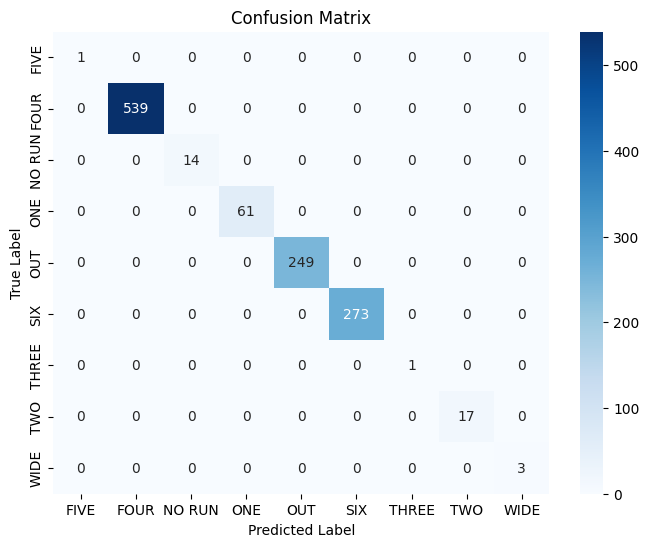

In [43]:
conf_matrix = confusion_matrix(y_true_decoded, y_pred_decoded)

# Plotting Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()